In [142]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime

now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
import lightgbm as lgb


import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

In [143]:
ratingDF = pd.read_csv('ratings.csv')

In [144]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: now.strftime("%m/%d/%Y, %H:%M:%S"))

In [145]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

In [146]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  162541
Number of unique movies:  59047
Number of total ratings:  25000095
Average number of ratings per user:  153.80793153727367


In [147]:
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
"rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       15117393
movieId      15117393
rating       15117393
timestamp    15117393
dtype: int64

In [148]:
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
"rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       97309
movieId      97309
rating       97309
timestamp    97309
dtype: int64

In [149]:
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1

In [150]:
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

In [151]:
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)

In [152]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

In [153]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  97309
Average number of ratings per user:  97.309


In [154]:
X_train, X_test = train_test_split(ratingDFX3,
test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test,
test_size=0.50, shuffle=True, random_state=2018)

In [155]:
print('Shape of train set:', X_train.shape)
print('Shape of validation set:',X_validation.shape)
print('Shape of test set: ',X_test.shape)

Shape of train set: (87578, 6)
Shape of validation set: (4865, 6)
Shape of test set:  (4866, 6)


In [156]:
print('Size of train set:', X_train.size)
print('Size of validation set:',X_validation.size)
print('Size of test set: ',X_test.size)

Size of train set: 525468
Size of validation set: 29190
Size of test set:  29196


Define the Cost Function: Mean Squared Error¶

In [157]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [158]:
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.76%


In [159]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [160]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

Perform Baseline Experiments

In [161]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [162]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5
pred_validation

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

In [163]:
mse = mean_squared_error(pred_validation, actual_validation)
rmse = np.sqrt(mse)
print("Mean  Squared Error is : ", mse)
print("Root Mean  Squared Error is : ", rmse)

Mean  Squared Error is :  1.0755395683453237
Root Mean  Squared Error is :  1.0370822379856497


In [164]:
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [165]:
pred_validation = ratings_validation_prediction  [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)
print('Root Mean Squared error using user average:' ,np.sqrt(user_average))

Mean squared error using user average: 0.8668820079789259
Root Mean Squared error using user average: 0.931064985905348


In [166]:
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [167]:
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)
print('Root Mean Squared error using movie average:' ,np.sqrt(movie_average))

Mean squared error using movie average: 0.9171585792533539
Root Mean Squared error using movie average: 0.9576839662714177


In [168]:
n_latent_factors = 1
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors,
name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1,
output_dim=n_latent_factors,
name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [169]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId],
                    y=X_train.rating, epochs=100,
                    validation_data=([X_validation.newUserId,
                                      X_validation.newMovieId], X_validation.rating),
                    verbose=1)

Epoch 1/100
2737/2737 [==============================] - 6s 2ms/step - loss: 13.4112 - val_loss: 11.0795
Epoch 2/100
2737/2737 [==============================] - 5s 2ms/step - loss: 8.2773 - val_loss: 5.6296
Epoch 3/100
2737/2737 [==============================] - 5s 2ms/step - loss: 3.9679 - val_loss: 2.8412
Epoch 4/100
2737/2737 [==============================] - 5s 2ms/step - loss: 2.1565 - val_loss: 1.7351
Epoch 5/100
2737/2737 [==============================] - 5s 2ms/step - loss: 1.3972 - val_loss: 1.2299
Epoch 6/100
2737/2737 [==============================] - 5s 2ms/step - loss: 1.0471 - val_loss: 0.9902
Epoch 7/100
2737/2737 [==============================] - 5s 2ms/step - loss: 0.8823 - val_loss: 0.8738
Epoch 8/100
2737/2737 [==============================] - 6s 2ms/step - loss: 0.8039 - val_loss: 0.8159
Epoch 9/100
2737/2737 [==============================] - 5s 2ms/step - loss: 0.7659 - val_loss: 0.7856
Epoch 10/100
2737/2737 [==============================] - 5s 2ms/step -

Minimum MSE:  0.7427254915237427


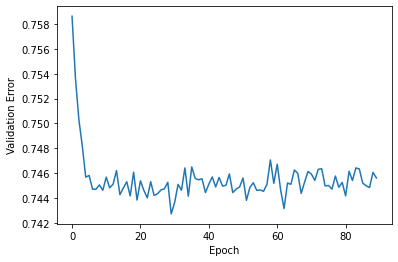

In [170]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [171]:
# n değişkeni, tavsiye edilen film sayısını belirleyecek olan N değerini temsil eder
n = 10

# Tüm filmleri diziye alalım
all_movies = np.arange(1, n_movies+1)

# Kullanıcı ID'si verilen kullanıcı için tahmin edilen ürün puanlarını hesaplayalım
predicted_ratings = model.predict([np.full(len(all_movies), 140 ), all_movies])#10  user_id

# Tahmin edilen ürün puanlarını sıralayalım
sorted_ratings = np.argsort(-predicted_ratings, axis=0)

# En yüksek puanlı filmleri seçelim
top_n_movies = sorted_ratings[:n]
print(top_n_movies)

32/32 [==============================] - 0s 1ms/step
[[107]
 [730]
 [144]
 [426]
 [685]
 [133]
 [425]
 [728]
 [163]
 [429]]


In [172]:
import pandas as pd

# movies.csv dosyasını Pandas DataFrame'ine okuyalım
movies = pd.read_csv("movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [173]:
# top_n_movies dizisindeki filmlerin isimlerini yazdıralım
for movie_id in top_n_movies:
  print(movie_id)

[107]
[730]
[144]
[426]
[685]
[133]
[425]
[728]
[163]
[429]


In [175]:

# Kullanıcı ID'si verilen kullanıcı için tahmin edilen ürün puanlarını hesaplayalım
all_movies = np.arange( 1, n_movies+1)
predicted_ratings = model.predict([np.full(len(all_movies),10), all_movies])

# Tahmin edilen ürün puanlarını sıralayalım
sorted_ratings = np.argsort(-predicted_ratings, axis=0)

# En yüksek puanlı filmleri seçelim
n = 10
top_n_movies = sorted_ratings[:n]
movie_title = ""
# top_n_movies dizisindeki filmlerin isimlerini yazdıralım
# top_n_movies dizisindeki filmlerin isimlerini yazdıralım
# top_n_movies dizisindeki filmlerin isimlerini yazdıralım
for movie_id in top_n_movies:
  movie_title = movies[movies['movieId'] == movie_id[0]]['title'].values[0]
  print(movie_title)


32/32 [==============================] - 0s 1ms/step
Muppet Treasure Island (1996)
Low Life (1994)
Brothers McMullen, The (1995)
Body Snatchers (1993)
It's My Party (1996)
Nueba Yol (1995)
Blue Sky (1994)
Cold Comfort Farm (1995)
Desperado (1995)
Cabin Boy (1994)


In [ ]:
movie_title